# Practical Session 5 - Parallel Markov chains with multiprocessing and dask

Students (pair):
- [Student 1]([link](https://github.com/username1))
- [Student 2]([link](https://github.com/username2))


**Useful references for this lab**:

[1] `seaborn`: [official tutorial](https://seaborn.pydata.org/tutorial.html)

[2] `multiprocessing`: [documentation](https://docs.python.org/3/library/multiprocessing.html), [doc2](https://he-arc.github.io/livre-python/multiprocessing/index.html)

[3] `dask`: [documentation](http://numba.pydata.org/) 

## <a name="content">Contents</a>
- [Exercise 1: seaborn, a useful tool for data visualisation](#ex1)
- [Exercise 2: Simulating a discrete-time homogeneous Markov chain](#ex2)
- [Bonus: Parallel computing with Dask](#bonus)
---

In [1]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: seaborn, a useful tool for data visualisation</a> [(&#8593;)](#content)
 
The `seaborn` package can significantly enhance data and data analysis visualization. See the [tutorial page](https://seaborn.pydata.org/tutorial.html) for examples of effective predefined graphics. An example aimed at visualizing the empirical distributions of 9 realizations of a bivariate Gaussian random vector is reported below.

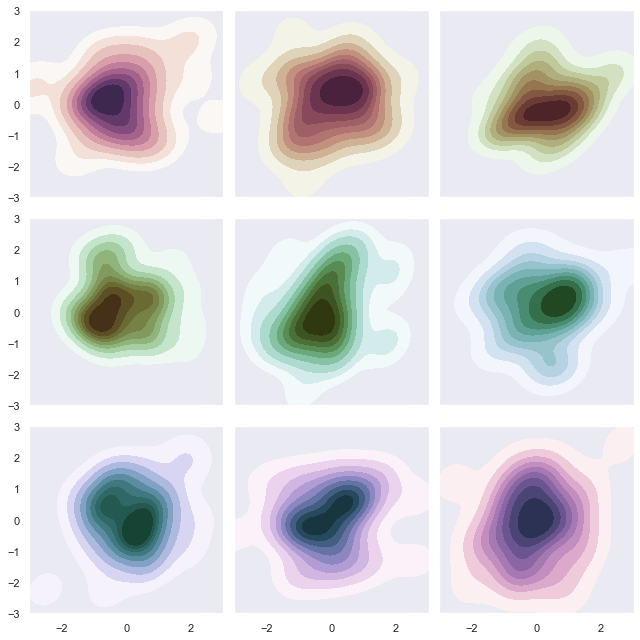

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="dark")
rng = np.random.default_rng(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rng.normal(size=(2, 50))
    sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

1. Comment on the lines of codes related to the `seaborn` library to make their role explicit. More specifically comment on the KDE method.

**Answer:**

sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax): The sns.kdeplot function from seaborn is used to create a Kernel Density Estimation plot. It visualizes the distribution of the data points. The x and y data are provided, and the colormap cmap is used to style the plot. The shade=True parameter fills the contours to give a shaded appearance. cut=5 truncates the density estimation beyond a certain limit, and ax=ax specifies the subplot to use for this plot.

2. For one of the realizations, take a look at the documentation of [`sns.jointplot`](https://seaborn.pydata.org/examples/joint_kde.html) to display both the 2-D empirical distribution of the data, and 1D histograms of their distribution along each axis. 

**Answer:**

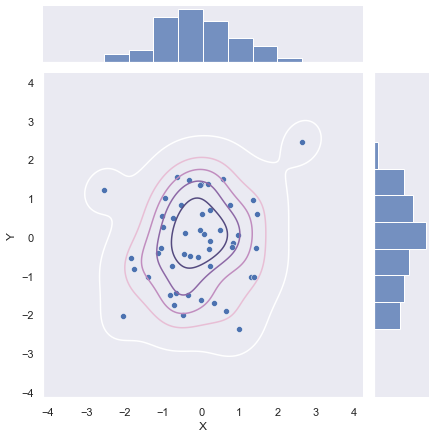

In [2]:
cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)
g = sns.jointplot( x=x, y=y)
g.plot_joint(sns.kdeplot, color="r",cmap=cmap, levels=6)
g.set_axis_labels(xlabel="X",ylabel="Y")

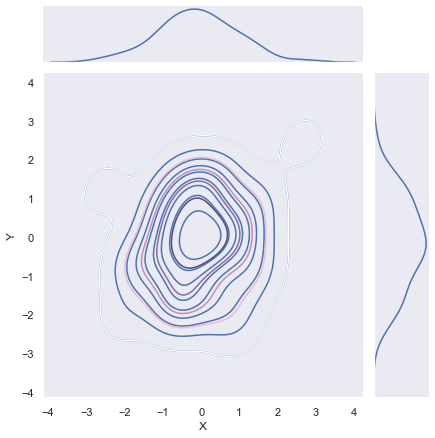

In [3]:
g = sns.jointplot(x=x,y=y,kind="kde")
g.plot_joint(sns.kdeplot, color="r",cmap=cmap, levels=6)
g.set_axis_labels(xlabel="X",ylabel="Y")

## <a name="ex2">Exercise 2: Simulating a discrete-time homogeneous Markov chain.</a> [(&#8593;)](#content)


Let ${(X_n)}_{n\geq 0}$ be a discrete-time homogeneous Markov chain with values over a finite ensemble $E=\{x_1,\dots,x_N\}$ identified to $\{1,\dots,N\}$. Consider $\boldsymbol{\rho} \in \Delta_N$, where $\Delta_N = \{\mathbf{x}\in\mathbb{R}^N \mid x_n \geq 0 \, \forall n \in \{1,\dotsc,N\} \text{ and } \sum_n x_n = 1 \}$ is the unit simplex in $\mathbb{R}^N$.

In the following, we consider the initial state of the chain $X_0$, following the discrete probability distribution:

$$
    \mathbb{P}(X_0 = k) = \rho_k, \qquad k \in \{1, \dots,  N\}.
$$
  
Let $\mathbf{A} = [a_{i,j}]_{i,j} \in \mathbb{R}^{N \times N}$ be the transition matrix of the chain, i.e.,

\begin{align*}
    &a_{i,j} = \mathbb{P}(X_{n+1} = j \mid X_{n} = i) \geq 0, \, \forall n \geq 0, \\
    &(\forall i \in \{1, \dotsc, N\}), \quad \sum_{j=1}^N a_{i,j} = 1.
\end{align*}
 
The chain is said to be homogeneous in that $\mathbf{A}$ does not depend from the time index $n$. Let $\tilde{a}_n$ represent the $n$-th row of $\mathbf{A}$. 

The trajectory of the chain can be simulated as follows:

>- Draw the discrete random variable $X_0$ with distribution $\boldsymbol{\rho}$;
>
>- For $q = 0$ to $n_{\text{iter}}-1$
>    - Draw the discrete random variable $X_{q+1}$ with distribution $\tilde{a}_{X_{q}}$;
>    
>- Return ${(X_q)}_{0 \leq q \leq n_{\text{iter}}}$.


<!-- If $X_n = k$, we know that $T$, the life time of the chain in the state $k$ obeys a geometric distribution with parameter $a_{kk}$. We also know that the probability of transition from k to $\ell\neq k$ is given by:

$$
    \mathbb{P}(X_{n+1}=\ell | X_n=k, \ell\neq k) = \frac{a_{k\ell}}{1-a_{kk}}.
$$

 ### One possible algorithm to simulate a Markov chain is therefore:

    a. generate the initial state $X_0$ according to the discrete law $\{\rho_1,\dots,\rho_N\}$.

    b. at instant $n$, knowing that $X_n=k$,

    i) determine the life time $T$ in state $X_n=k$ by simulating a geometrical variable with parameter $a_{kk}$. As a consequence $X_n = \dots = X_{n+T} = k$. When $T=0$, we simply still have $X_n=k$.

    ii) determine next transition instant $n+T$, and determine the next state by using the probabilities of transition. -->

1. Implement the above algorithm in a function `X = markov(rho,A,nmax,rng)` with:
     - `rho`: law of the initial state (nonnegative vector of size $N$, summing to 1),
     - `A`: transition matrix (of size $N\times N$) 
     - `nmax`: number of time steps,
     - `rng`: random number generator
     - `X`: trajectory of the chain.
     
In particular, check the input parameters `A` and `rho` make sense by adding appropriate assertions (or raising exceptions).
   - Examples : **transition matrix `A` should be square** ; **expected `A` to be a stochastic matrix** ; **verify if the size of `A` and `rho` are consistent** ; **verify if `rho` is in the unit simplex**
     - `np.allclose`, `np.isclose` and `np.all` could be useful

> Hints:
> - the function `np.random.choice` can be useful to draw discrete random variables.
> - use `states = np.arange(N)` to create the the labels of the states (from $0$ up to $N-1$)

Here is an example of execution : 
![alternatvie text](img/For_CourseM.png)

**Answer:**

In [3]:

def markov(rho, A, nmax, rng):
    """"
     Function that implements markov chain
     Parameters:
        - `rho`: law of the initial state (nonnegative vector of size N, summing to 1),
        - `A`: transition matrix (of size N x N) 
        - `nmax`: number of time steps,
        - `rng`: random number generator
        
    Returns : 
        - `X`: trajectory of the chain.
    """
    
    # Vérifications des paramètres d'entrée
    N = len(rho)
    assert len(A) == N and A.shape[0] == A.shape[1], "La matrice de transition A doit être carrée."
    assert np.all(np.isclose(np.sum(A, axis=1), 1)), "La matrice de transition A doit être stochastique."
    assert np.all(rho >0), "les valeur de rho doivent étre positives"
    assert np.all(np.isclose(rho.sum(), 1)), "Le vecteur rho doit se sommer à 1 "
    assert nmax > 0, "Le nombre d'itérations nmax doit être strictement positif."
    np.random.seed(rng)
    states = np.arange(N)
    X = np.empty(nmax, dtype=int)
    
    # Générer l'état initial X_0 selon la loi rho
    X[0] = np.random.choice(states, p=rho)
    
    for q in range(1, nmax):
        # Calculer la distribution de probabilité pour X_{q+1} (a_{X_q} est la ligne correspondant à X_q)
        transition_probs = A[X[q - 1]]
        # Générer X_{q+1} selon la distribution de probabilité
        X[q] = np.random.choice(states, p=transition_probs)
    
    return X




2. Set the random number generator to a known state. Make a few simulations using simple transition matrices (*i.e.*, taking any nonnegative matrix $A=(a_{i,j})$ such that its lines sum to 1) and display the trajectory of the chains.

**Answer:**

[1 2 1 2 2 2 2 2 1 0]


Text(0, 0.5, 'trajectory')

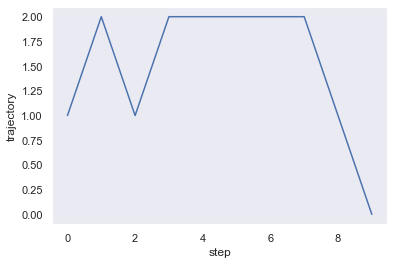

In [4]:
# Exemple d'utilisation :
N = 3
rho = np.array([0.2, 0.3, 0.5])
A = np.array([[0.4, 0.3, 0.3],
              [0.2, 0.5, 0.3],
              [0.1, 0.2, 0.7]])

rng =5
nmax = 10

X = markov(rho, A, nmax, rng)
print(X)
plt.plot([i for i in range(len(X))],X)
plt.xlabel("step")
plt.ylabel("trajectory")

In [5]:
def generate_markov_parameters(N):
    """Generator of markov parameters

    Args:
        N (int): dimention of parameters

    Returns:
        A (array NxN):transition matrix
        `rho`: law of the initial state (nonnegative vector of size N, summing to 1),
    """
    # Générer une matrice de transition aléatoire (stochastique)
    A = np.random.rand(N, N)
    A /= A.sum(axis=1, keepdims=True)

    # Générer un vecteur rho aléatoire dans le simplexe unité
    rho = np.random.dirichlet(np.ones(N))

    return A, rho

# Exemple d'utilisation :
N = 4  # Nombre d'états de la chaîne
transition_matrix, initial_distribution = generate_markov_parameters(N)
print("Matrice de transition :")
print(transition_matrix)
print("Distribution initiale :")
print(initial_distribution)
np.all(np.isclose(np.sum(transition_matrix, axis=1), 1))


Matrice de transition :
[[0.05690811 0.52046797 0.31104385 0.11158006]
 [0.47198353 0.1470154  0.22218874 0.15881233]
 [0.30312176 0.27952423 0.28920975 0.12814426]
 [0.28186656 0.25107685 0.32431999 0.1427366 ]]
Distribution initiale :
[0.02610146 0.4789471  0.46485557 0.03009586]


True

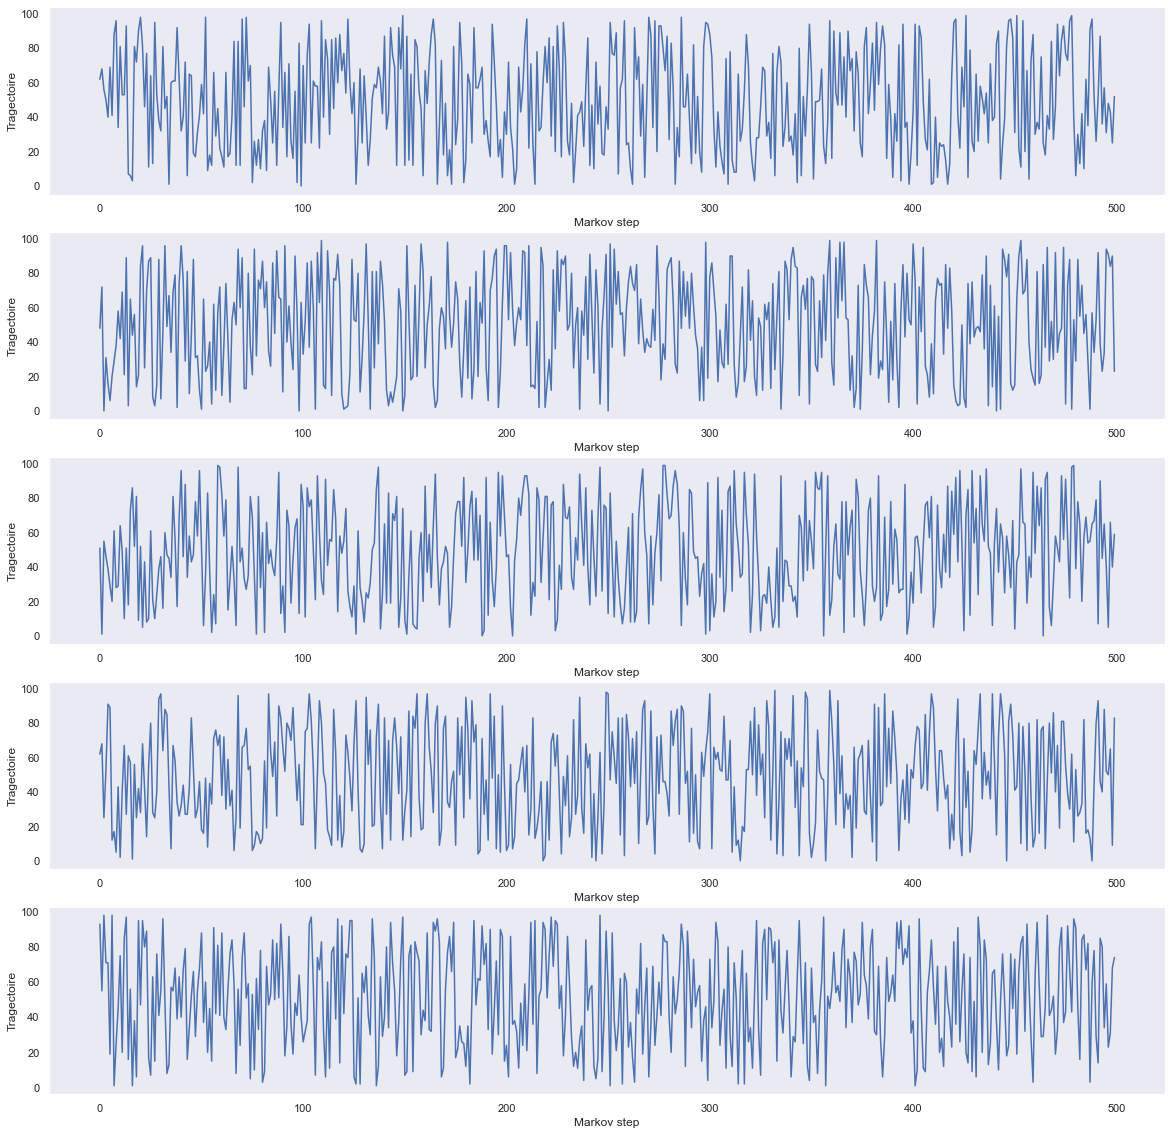

In [6]:
import Markov

A, rho = Markov.generate_markov_parameters(100)

plt.figure(figsize=(20, 20))

for rng in range(5):
    X = Markov.markov(rho, A, 500, rng)
    Y = [i for i in range(len(X))]
    plt.subplot(5, 1, rng+1)
    plt.plot(Y, X)
    plt.xlabel("Markov step")
    plt.ylabel("Tragectoire")
    
plt.show()



# Remark :
The markov function provides a versatile tool for simulating random walks using Markov chains. By defining transition probabilities and an initial state distribution, you can model a wide range of stochastic processes, from simple random walks to more complex systems. This function is particularly valuable in the fields of finance, physics, and data science, where random walks are used to model stock prices, particle motion, and various probabilistic phenomena. With the ability to specify transition matrices and an arbitrary number of time steps.

* Now we will code a function that shows the markov chain using networks 

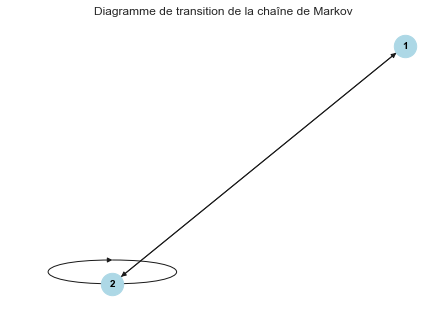

In [7]:
import networkx as nx

def plot_markov_chain(transition_sequence):
    # Crée un graphique dirigé
    G = nx.DiGraph()
    
    # Parcours la séquence de transition et ajoute les arêtes
    for i in range(len(transition_sequence) - 1):
        current_state = transition_sequence[i]
        next_state = transition_sequence[i + 1]
        G.add_edge(current_state, next_state)
    
    # Crée la disposition du graphique
    pos = nx.spring_layout(G)
    
    # Dessine les nœuds et les arêtes
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black', font_weight='bold')
    plt.title("Diagramme de transition de la chaîne de Markov")
    
    # Affiche le graphique
    plt.show()


transition_sequence = [1, 2, 1, 2, 2, 2, 2, 2, 1]
plot_markov_chain(transition_sequence)


[5 3 5 4 4 1 4 0 1 2]


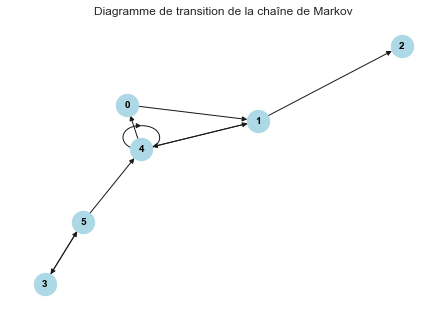

In [8]:
import Markov
A, rho = Markov.generate_markov_parameters(6)
X = Markov.markov(rho, A, 10, 4)
print(X)
plot_markov_chain(X)

3. Explore the potential of the [`multiprocessing` package](https://docs.python.org/3/library/multiprocessing.html) to simulate several Markov chains in parallel.

> Hint: the `mutiprocessing.Pool.starmap` or `mutiprocessing.Pool.starmap_async` methods could be useful.

- To use multiprocessing package we are obliged to write our function to which we want to compute using multiprocessing and call it ,otherwise the cell doesn't finish running . 

We will use the function Pool to run different markov chains at the same time and we will time it and compare it to the normal computing of this chains

In [8]:
from multiprocessing import Pool
from  Markov import markov
import time

if __name__ == '__main__':
    start = time.process_time() 
    num_processors = 10
    p = Pool(processes=num_processors)
    A, rho = Markov.generate_markov_parameters(100)
        
    # Préparez une liste d'arguments pour chaque appel à la fonction markov
    args_list = [(rho,A, 1000, rng) for rng in range(5)]
    with Pool(processes=4) as pool:

        # Simulate the Markov chains in parallel
        results = pool.starmap(markov,args_list)
    

    print('Timing with multiprocessing', time.process_time()- start,'seconds') 
   

Timing with multiprocessing 0.015625 seconds


In [9]:
start = time.process_time() 
A, rho = Markov.generate_markov_parameters(100)
X = []
for rng in range(5):
    X.append(markov(rho, A, 1000, rng))
print('Timing Using the normal process', time.process_time()- start,'seconds') 


Timing Using the normal process 0.09375 seconds


- We see that using multiprocessing reduces clearly the time of computing 5 markov chains .
- Now let's see the influence of using multiprocessing on computational time compared to the normal computing of markov functions

In [10]:
Time_multiP = []
Time =[]
for i in range(1,20):
    start = time.process_time() 
    A, rho = Markov.generate_markov_parameters(10)
        
    # Préparez une liste d'arguments pour chaque appel à la fonction markov
    args_list = [(rho,A, 1000, rng) for rng in range(i)]
    with Pool(processes=i) as pool:

        # Simulate the Markov chains in parallel
        results = pool.starmap(markov,args_list)
    stop = time.process_time()
    Time_multiP.append(stop-start)
    start = time.process_time()
    X = []
    for rng in range(i):
        X.append(Markov.markov(rho, A, 1000, rng))
    stop = time.process_time()
    Time.append(stop-start)

    
    

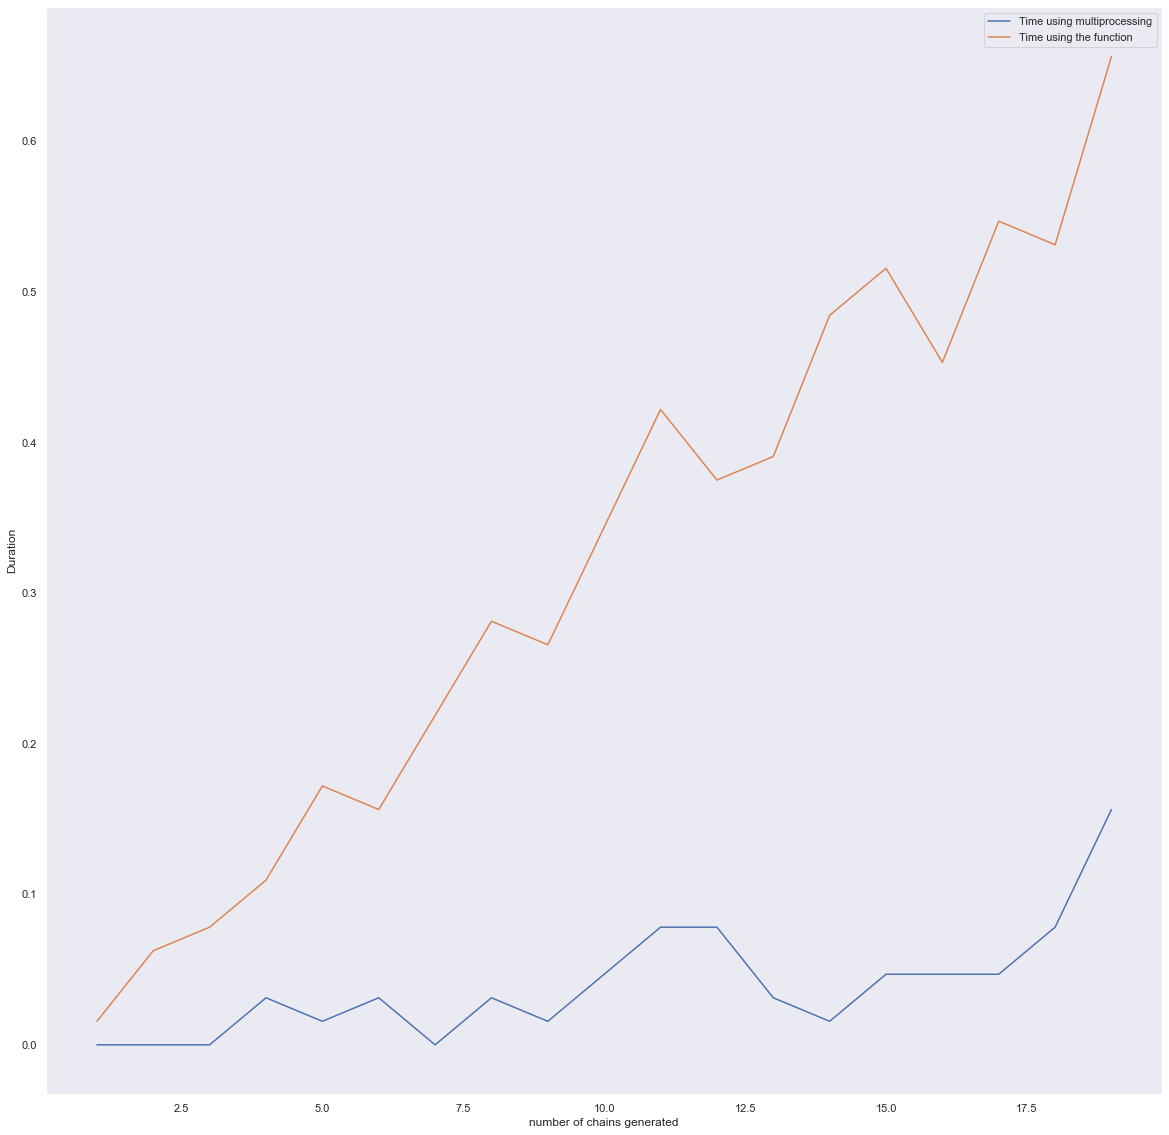

In [11]:
plt.figure(figsize=(20,20))
plt.plot([i+1 for i in range(len(Time_multiP))],Time_multiP,label="Time using multiprocessing")
plt.plot([i+1 for i in range(len(Time))],Time,label="Time using the function")
plt.xlabel("number of chains generated")
plt.ylabel("Duration")
plt.legend()


# Results : 
  
  Its normal that the computational time of the normal function goes up when the number of markov chains to compute increases.In the other hand the multi processing function time's is really small compared to the normal process, other thing we see that the computational time using multiprocessing library remains stable .

4. [Bonus] Generate Markov chains in parallel with the [`dask`](https://docs.dask.org/en/latest/futures.html) library, which offers more general parallelization functionalities (with, for instance, the use of [`Futures`](https://docs.dask.org/en/stable/futures.html), see tutorial [here](https://tutorial.dask.org/05_futures.html)). A useful example is provided [here](https://stackoverflow.com/questions/41471248/how-to-efficiently-submit-tasks-with-large-arguments-in-dask-distributed). Note that `dask` is much more versatile and powerful than `multiprocessing`, and can be useful to scale algorithms over multiple cores and/or computing nodes.

**Answer:**

In [2]:
import dask
from dask import delayed



In [58]:
# Calculating the average time using multipocessing
N = 10
average_time = 0
chains = 5
params = [(rho, A, 500, rng) for rng in range(chains)]


for i in range(N) : 

    start = time.process_time()

    
    with Pool(processes=chains) as pool:

        results = pool.starmap(markov, params)
    end = time.process_time()

    average_time += (end- start)/N

print('Average Timing with Multiprcessing', average_time,'seconds')

Average Timing with Multiprcessing 1.1953125 seconds


In [60]:
# Calculating the average time using Dask
average_time = 0

for i in range(N) : 

    start = time.process_time()


    # Using Dask to parallelize the generation of Markov chains
    results = dask.compute([markov(rho,A,500, i) for i in range(5)]) # Create a list of parameters for the Markov chains
    end = time.process_time()
    average_time += (end - start)/N
   
print('Average Timing with dask', average_time,'seconds')

Average Timing with dask 0.035937500000000004 seconds


It seems like dask overcomes multiprossecing in terms of run time .Dask is designed for both local and distributed computing. It can scale from a single machine with multiple cores to clusters of machines. Its ability to distribute computations can lead to shorter runtimes when dealing with massive datasets or computationally intensive tasks.
In other hand multiprocessing primarily provides local parallelism on a single machine. It's effective for utilizing multiple CPU cores but may not offer the same level of scalability as Dask for distributed computing.

## <a name="bonus">Bonus: Parallel computing with Dask</a> [(&#8593;)](#content)

1. Take a look at the [`dask.array` documentation](https://docs.dask.org/en/stable/array-best-practices.html) and the associate [tutorial](https://tutorial.dask.org/02_array.html). Apply some of the functions introduced herein and in the [documentation](https://docs.dask.org/en/stable/array-best-practices.html) to parallelize the computation of the total variation investigated during session 2. Note that you can combine `dask` and `numba` to obtain an overall more efficient implementation. Note that timing can be worse than Numpy (`dask.array` is more specifically interesting when the data do no fit in memory).

2. Take a look at the [`dask.delayed` tutorial](https://tutorial.dask.org/03_dask.delayed.html), and go through some of the examples provided. [Best practices with the `dask.delayed` interface](https://docs.dask.org/en/stable/delayed-best-practices.html) are summarized in the documentation.

> **Remark**: an alternative to Dask: the [Ray](https://docs.ray.io/en/latest/) library.

**Answer:**

In [1]:
import time
import dask
from dask import delayed

- Total variation for the 2D gradient adjoint using dask 

In [4]:
import dask.array as da

from dask.distributed import Client

def gradient2D_dask(X):
    assert X.ndim == 2, 'The input array must be 2D'

    # Compute horizontal differences with a column of zeros appended
    Yh = da.concatenate([da.diff(X, axis=1), da.zeros((X.shape[0], 1))], axis=1)
    # Compute vertical differences with a row of zeros appended
    Yv = da.concatenate([da.diff(X, axis=0), da.zeros((1, X.shape[1]))], axis=0)
    return Yh, Yv
# Create a dask.array from a numpy array

def TV_dask(X):
    assert X.ndim == 2, 'The input array must be 2D'
    
    # Calculate the gradients using the gradient2D function
    Yh, Yv = gradient2D_dask(X)

    # Compute the squared sum of total variation using dask
    squared_sum_tv = da.sqrt(da.sum(Yh ** 2) + da.sum(Yv ** 2))

    # Compute the result and return as a NumPy array
    result = squared_sum_tv.compute()
    return result



In [5]:
# Generate a random 2D array for testing
X = np.random.random((100,50, 50))
X_dask = da.from_array(X, chunks=(10*100,10*50, 10*50))
client = Client()


In [6]:

start = time.process_time()
futures = [client.submit(TV_dask, X_dask[j]) for j in range(100)]

# parallelize the calculations
results = dask.compute(*futures)
end = time.process_time()
print(f"The duration of dask function is : {end-start} seconds")

The duration of dask function is : 0.109375 seconds


- Summary :
In summary, while Numpy provides fast calculations, Dask becomes indispensable when working with extensive datasets that surpass the available memory capacity


- Now let's see what we can do with delayed function and for that we will wright our functions using minimum numpy functiions 

In [2]:
@delayed
def TV_loop(X):
    assert X.ndim == 2, 'The input array must be 2D'

    # Calculate the gradients using the gradient2D function
    Yh, Yv = gradient2D(X)

    # Compute the squared sum of total variation
    squared_sum_tv = 0.0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            squared_sum_tv += Yh[i, j] ** 2
            squared_sum_tv += Yv[i, j] ** 2
    squared_sum_tv = np.sqrt(squared_sum_tv)

    return squared_sum_tv
@delayed
def gradient2D_loop(X):
    
    assert X.ndim == 2, 'The input array must be 2D'
    Yh = np.zeros_like(X, dtype=X.dtype)
    Yv = np.zeros_like(X, dtype=X.dtype)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1] - 1):
            Yh[i, j] = X[i, j + 1] - X[i, j]
        Yh[i, -1] = 0.0  # Zero-padding the last column
    
    for i in range(X.shape[0] - 1):
        for j in range(X.shape[1]):
            Yv[i, j] = X[i + 1, j] - X[i, j]
    Yv[-1, :] = 0.0  # Zero-padding the last row
    
    return Yh, Yv



In [4]:
X = np.random.random((1000,50, 50)) #We increased the size of our array in order to see the run time otherwize its 0.0 seconds

results = []

start = time.process_time()

for x in X : 

    results.append(TV_loop(x))

end = time.process_time()
print(f'The duration  of delay parallel functionsis :   {end-start} seconds ')


The duration  of delay parallel functionsis :   0.15625 seconds 


- Now let's see the run time using the simple functions without delayed function 

In [5]:

def TV(X):
    assert X.ndim == 2, 'The input array must be 2D'

    # Calculate the gradients using the gradient2D function
    Yh, Yv = gradient2D(X)

    # Compute the squared sum of total variation
    squared_sum_tv = 0.0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            squared_sum_tv += Yh[i, j] ** 2
            squared_sum_tv += Yv[i, j] ** 2
    squared_sum_tv = np.sqrt(squared_sum_tv)

    return squared_sum_tv
def gradient2D(X):
    
    assert X.ndim == 2, 'The input array must be 2D'
    Yh = np.zeros_like(X, dtype=X.dtype)
    Yv = np.zeros_like(X, dtype=X.dtype)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1] - 1):
            Yh[i, j] = X[i, j + 1] - X[i, j]
        Yh[i, -1] = 0.0  # Zero-padding the last column
    
    for i in range(X.shape[0] - 1):
        for j in range(X.shape[1]):
            Yv[i, j] = X[i + 1, j] - X[i, j]
    Yv[-1, :] = 0.0  # Zero-padding the last row
    
    return Yh, Yv



In [6]:
results = []

start = time.process_time()

for x in X : 

    results.append(TV(x))

end = time.process_time()
print(f'The duration  of  loop function is :   {end-start} seconds ')

The duration  of  loop function is :   4.03125 seconds 


We see clearly that delayed feature overcames normal functions in terms of run time 

# Conclusions:

- Multiprocessing is great for utilizing multiple CPU cores on a single machine for CPU-bound tasks.
- Dask is a comprehensive framework for parallel and distributed computing, suitable for a wide range of tasks, from single-machine parallelism to distributed clusters, especially for out-of-core or larger-than-memory computing.
- Dask Delayed is a specific Dask feature for custom parallelization of code by creating delayed objects, making it a valuable tool for those seeking to parallelize non-trivial operations in a Dask context.
